In [1]:
## import libraries
import sys
import glob
import re
import textwrap
from scipy.ndimage import gaussian_filter

import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, plot_terrain
import customcmaps as ccmaps
from trajectory_post_funcs import load_trajectories
from utils import roundPartial, select_months_ds

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:3857") # have to manually set the projection
## set a column to be the first two numbers 
## get first two numbers of HUC8
basin_number = polys['HUC8'].values
newlist = [x[:2] for x in basin_number]
polys['basin'] = newlist
poly = polys.dissolve(by='basin', aggfunc='sum')
poly['basin'] = [10, 11, 13, 14]
poly

,geometry,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,States,HUC8,Name,Shape_Leng,Shape_Area,basin
basin,,,,,,,,,,,,,,,,,
10,"POLYGON ((-105.86763 39.49419, -105.86738 39.4...",1459,{88F45F9F-080F-45EF-9653-CC111BD4D053}{E180B15...,0,0,0,0,2012-06-112012-06-112012-06-112012-06-112012-0...,0,29440289.37,119140.77,"COCOCOCO,KS,NECO,NECO,NECOCO,NE,WYCO,NECO,WYCO...",1019001110190013101900141025000110250005101900...,BijouBeaverPawneeArikareeFrenchmanLower South ...,146.538055,12.613489,10
11,"POLYGON ((-103.03204 36.72690, -103.03261 36.7...",984,{FD7D8C74-67B1-4679-A903-413DB9337C81}{2BD36A3...,0,0,0,0,2016-10-112012-06-112012-06-112012-06-112012-0...,0,23931227.67,96846.34,"COCOCO,NMCOCOCO,KS,NM,OKCOCO,NM,OKCOCO,NMCO,KS...",1102000211020006110800011102000811020012110400...,Upper ArkansasHuerfanoCanadian HeadwatersHorse...,102.935513,9.929023,11
13,"POLYGON ((-105.23421 37.03533, -105.23449 37.0...",343,{3C828B69-1041-4E06-98D9-546F1A0AB778}{72C226B...,0,0,0,0,2012-06-112012-06-112017-09-202012-06-112017-0...,0,8975607.30,36323.02,"CO,NMCO,NMCO,NMCOCO,NMCOCO",1301000513020102130100021301000413020101130100...,ConejosRio ChamaAlamosa-TrincheraSaguacheUpper...,33.428383,3.681679,13
14,"POLYGON ((-108.25677 36.48243, -108.25707 36.4...",1492,{75740F8C-AFFA-40B5-908E-4911BCB38D0B}{9CE10C9...,0,0,0,0,2012-06-112012-06-112012-06-112012-06-112012-0...,0,35639918.22,144229.79,"CO,NMAZ,CO,NMCOCOCOCO,WYCO,UTCOCO,UTCO,UTCO,WY...",1408010714080105140200051402000214050002140401...,MancosMiddle San JuanLower GunnisonUpper Gunni...,144.552341,15.010810,14


In [4]:
def round_latlon_degree(df, res):

    df['lon'] = roundPartial(df['lon'], res)
    df['lat'] = roundPartial(df['lat'], res)
    
    return df
    
def get_landfall_locs(ds, start_mon, end_mon):
    ## subset to months
    ds = select_months_ds(ds, start_mon, end_mon, 'start_date')
    df_lst = []
    for i, HUC8 in enumerate(ds.HUC8.values):
    
        tmp = ds.sel(HUC8=HUC8)
        tmp = tmp.where(tmp['ar_scale'] > 0, drop=True)
        time_match = tmp.time_match.values
        lat_match = tmp.lat_match.values
        lon_match = tmp.lon_match.values
        start_date = tmp.start_date.values
        
        d = {'landfall_time': time_match, 'lat': lat_match, 'lon': lon_match, 
             'HUC8': tmp.HUC8.values, 'start_date': start_date}
        df = pd.DataFrame(d)
        df_lst.append(df)
    
    df = pd.concat(df_lst)
    df = round_latlon_degree(df, 0.5)
    df2 = df.pivot_table(index = ['lat', 'lon'], aggfunc ='size')
    df2
    df2 = df2.reset_index()
    colname = df2.columns[-1]
    
    return colname, df2

In [5]:
## load trajectories
ds = load_trajectories('combined_extreme_AR')

colname1, df1 = get_landfall_locs(ds, 1, 12)

In [6]:
df1

,lat,lon,0
0,19.0,-104.0,1
1,21.0,-97.5,1
2,22.5,-98.0,12
3,23.0,-98.0,1
4,23.5,-98.0,1
...,...,...,...
107,54.5,-130.5,1
108,55.0,-131.0,2
109,57.0,-92.0,2
110,57.0,-91.0,1


In [7]:
# fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
# PRISM = xr.open_dataset(fname)
# PRISM = PRISM.sel(HUC8='10190002')
# PRISM.where(PRISM.extreme > 0, drop=True)

In [8]:
# HUC8 = '10190002'
# ds = load_trajectories('combined_extreme_AR')
# ds = ds.sel(HUC8=HUC8)
# AR = ds.where(ds.ar_scale > 1, drop=True)
# dates = AR.start_date.values
# print(dates)

In [9]:
# len(dates)

In [10]:
# HUC8 = '10190002'
# fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
# PRISM = xr.open_dataset(fname)
# PRISM = PRISM.sel(HUC8=HUC8, date=dates)
# PRISM.prec.values

In [11]:
# d = {'date': dates, 'prec': PRISM.prec.values}
# tmp = pd.DataFrame(d)
# tmp.sort_values(by='prec', ascending=False)

In [12]:
# ## load trajectories
# ds = load_trajectories('combined_extreme_AR')
# ds = ds.where(ds.basin=='Colorado', drop=True)
# AR = ds.where(ds.ar_scale > 4, drop=True)
# AR
# AR.sel(start_date='2021-10-27')

In [13]:
ext = [-129., -90., 22, 50]
# Set up projection
# mapcrs = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=39)
# mapcrs = ccrs.LambertConformal(central_longitude=-96, central_latitude=39)
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

In [14]:
## for each regime we have
# arrow
# arrow label top
# arrow label bottom
# precip label top
# precip label bottom

# styledict = {
#     'cool-season baja' : {
#         'color' : '#01497c', ## color of arrow and text
#         'rad': -0.3, ## radius of arrow
#         'mutation_scale': 150, ## size of arrow
#         'x': -106.8317, ## longitude of arrow start
#         'y': 40., ## latitude of arrow start
#         'direction': 200, # the direction in radians that the arrow is coming from
#         'distance': 20, # this distance of the end point of the arrow
        
#         'bottom_text1' : {
#             'lbl' : textwrap.fill('days per year', width=16),
#             'lbl_coords': 
#             'lbl_offset': 
#             'styledictname': 'style1'
#         bottom_text2 = textwrap.fill('cool-season precipitation', width=14)
#         top_text1 = '21'
#         top_text2 = '30–80%'
#     }
#     }
# }

In [19]:
styledict = {
    'cool-season baja' : {
        'color' : '#01497c', ## color of arrow and text
        'rad': -0.3, ## radius of arrow
        'mutation_scale': 21, ## size of arrow
        'x': -106.8317, ## longitude of arrow start
        'y': 38., ## latitude of arrow start
        'direction': 210, # the direction in radians that the arrow is coming from
        'distance': 18, # this distance of the end point of the arrow
    },
    'cool-season gulf' : {
        'color' : '#01497c', ## color of arrow and text
        'rad': -0.3, ## radius of arrow
        'mutation_scale': 2, ## size of arrow
        'x': -102.5, ## longitude of arrow start
        'y': 38., ## latitude of arrow start
        'direction': 260, # the direction in radians that the arrow is coming from
        'distance': 16, # this distance of the end point of the arrow
    },
    'cool-season pnw' : {
        'color' : '#01497c', ## color of arrow and text
        'rad': -0.2, ## radius of arrow
        'mutation_scale': 7, ## size of arrow
        'x': -108.5, ## longitude of arrow start
        'y': 40., ## latitude of arrow start
        'direction': 140, # the direction in radians that the arrow is coming from
        'distance': 18, # this distance of the end point of the arrow
    },
    'warm-season baja' : {
        'color' : '#962163', ## color of arrow and text
        'rad': -0.3, ## radius of arrow
        'mutation_scale': 14, ## size of arrow
        'x': -109., ## longitude of arrow start
        'y': 38., ## latitude of arrow start
        'direction': 230, # the direction in radians that the arrow is coming from
        'distance': 14, # this distance of the end point of the arrow
    },
    'warm-season gulf' : {
        'color' : '#962163', ## color of arrow and text
        'rad': -0.3, ## radius of arrow
        'mutation_scale': 10, ## size of arrow
        'x': -102.5, ## longitude of arrow start
        'y': 38., ## latitude of arrow start
        'direction': 275, # the direction in radians that the arrow is coming from
        'distance': 16, # this distance of the end point of the arrow
    },
    'warm-season pnw' : {
        'color' : '#962163', ## color of arrow and text
        'rad': -0.2, ## radius of arrow
        'mutation_scale': 4, ## size of arrow
        'x': -108.5, ## longitude of arrow start
        'y': 40., ## latitude of arrow start
        'direction': 145, # the direction in radians that the arrow is coming from
        'distance': 18, # this distance of the end point of the arrow
    },
    }


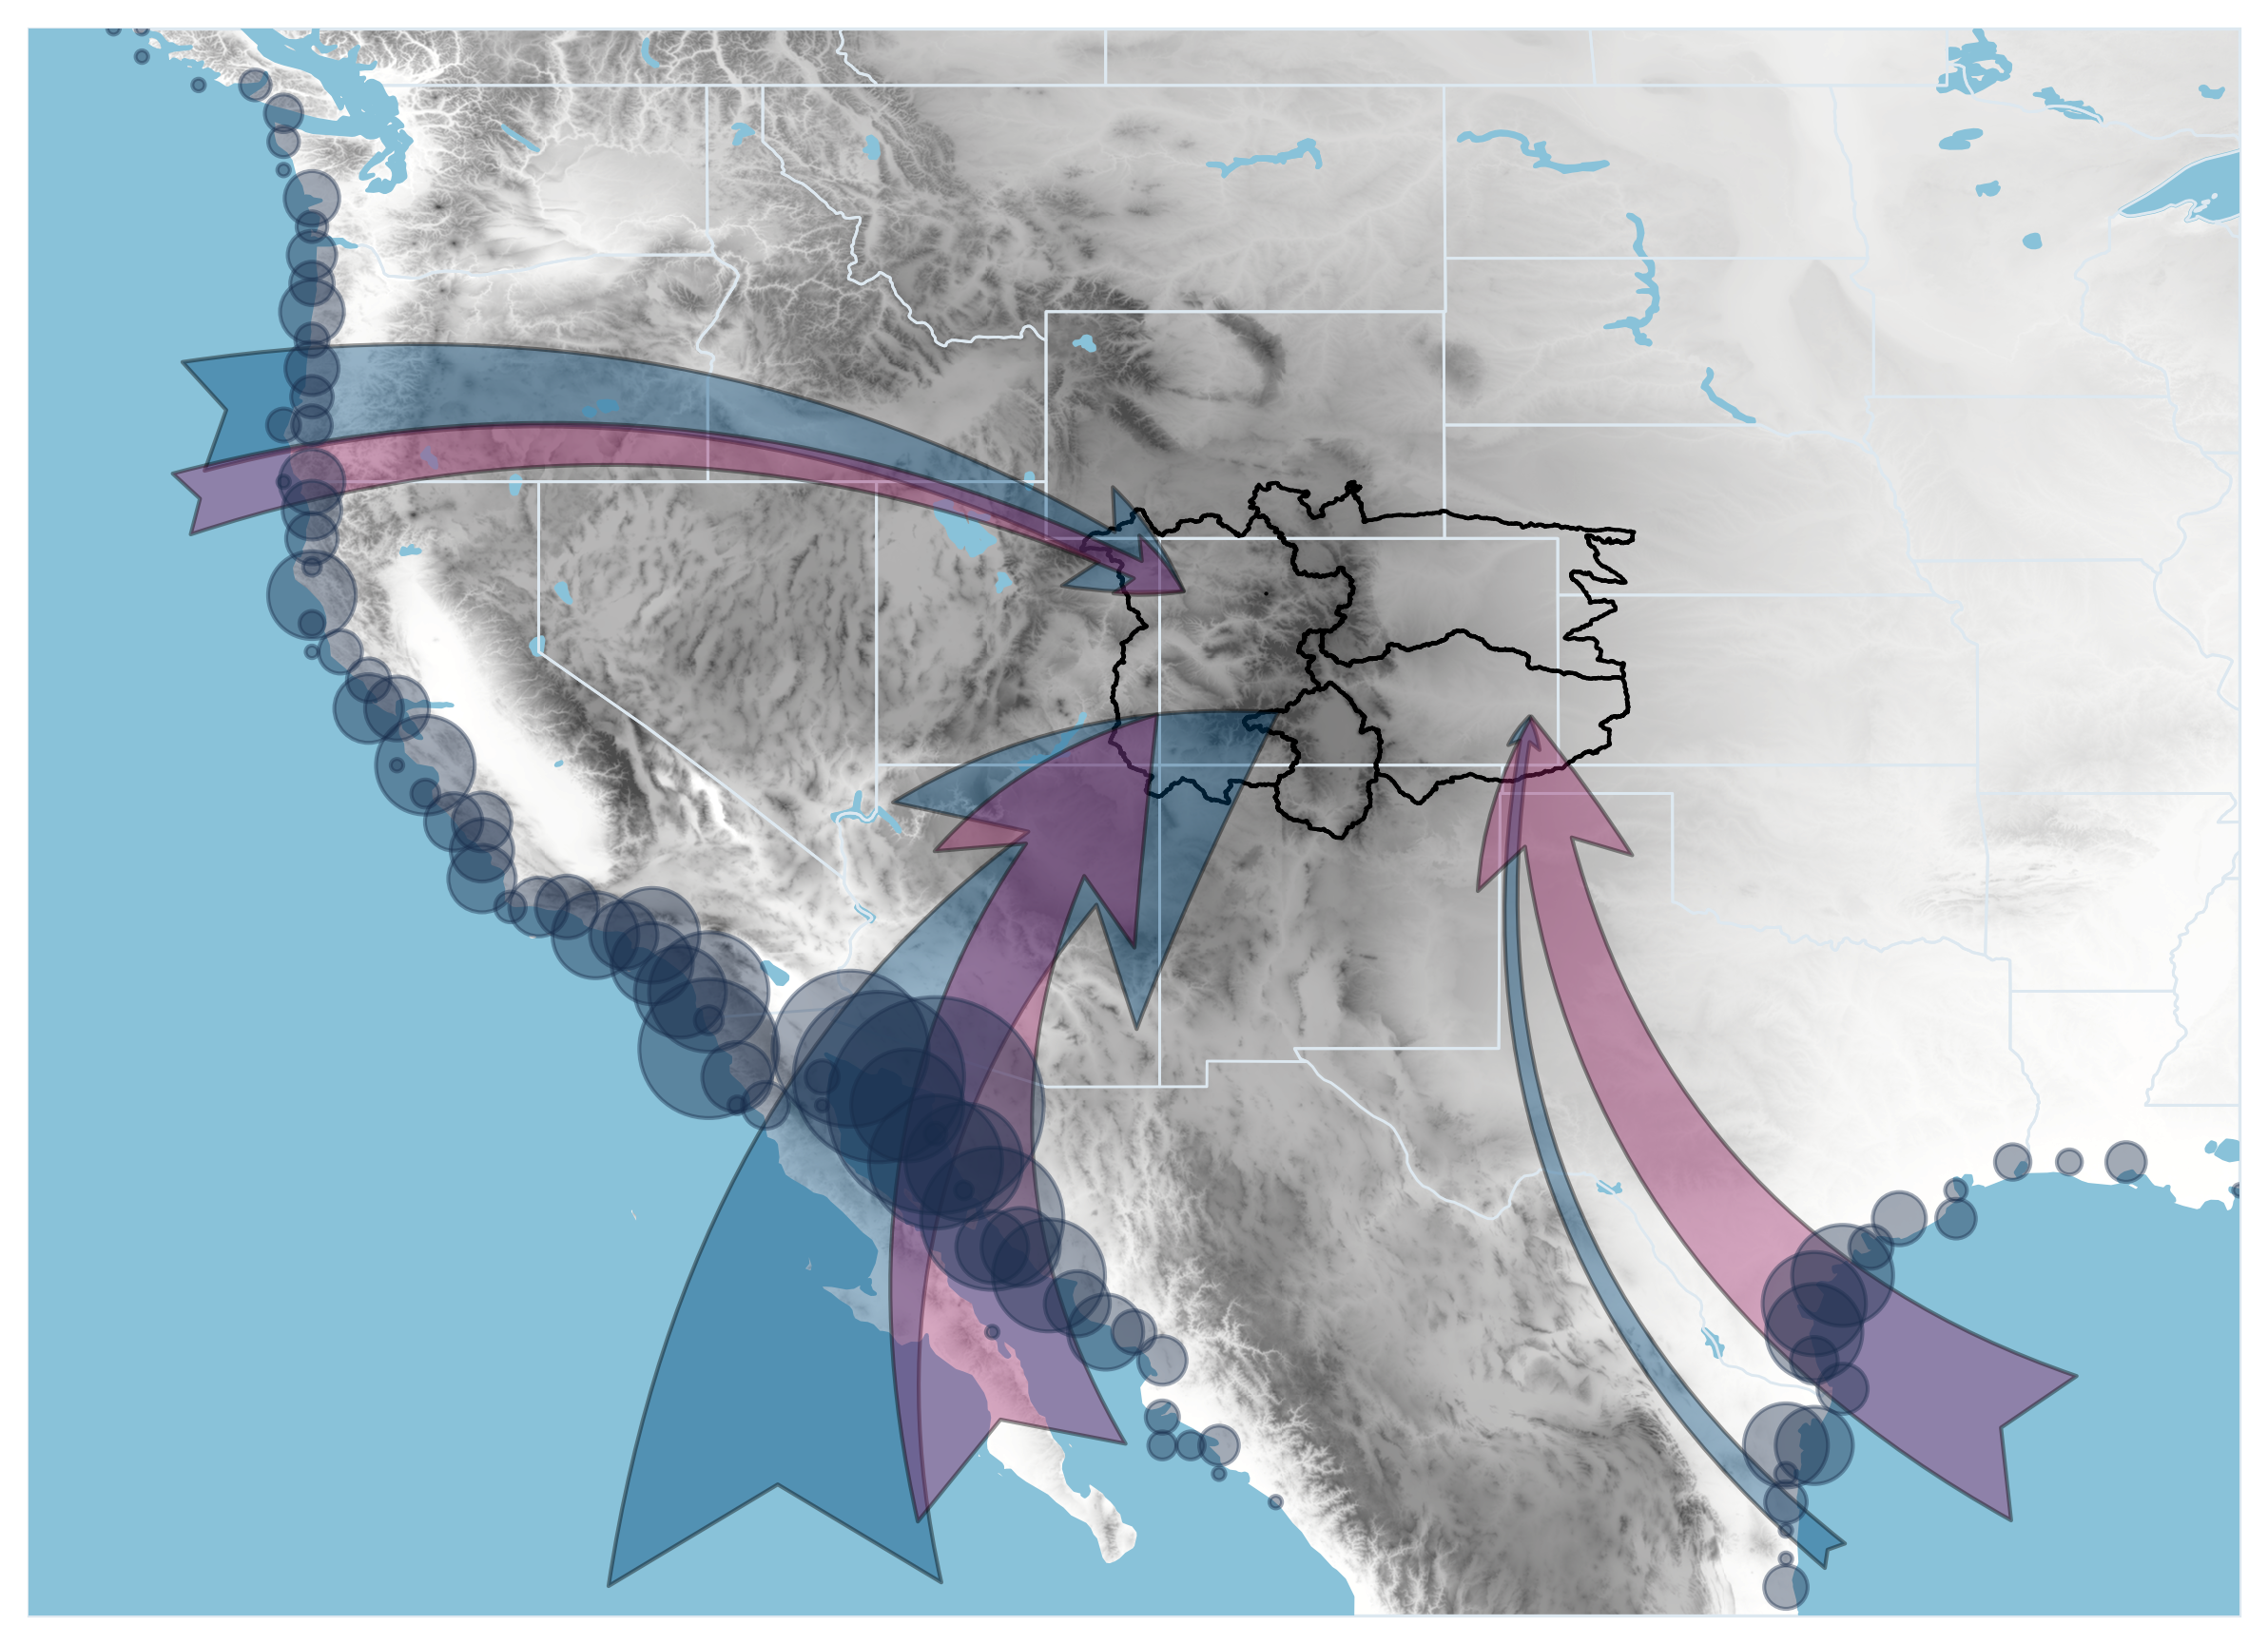

In [20]:
# Create figure
fig = plt.figure(figsize=(10, 15))
fig.dpi = 300
fname = path_to_figs + 'schematic'
fmt = 'png'

nrows = 2
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1], width_ratios = [1], wspace=0.02, hspace=0.02)
## use gs[rows index, columns index] to access grids

#### Add topography map with labels
ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
ax.set_extent(ext, crs=datacrs)
ax.add_feature(cfeature.OCEAN, edgecolor='#89C2D9', zorder=6, facecolor='#89C2D9') # mask ocean
ax.add_feature(cfeature.LAKES, edgecolor='#89C2D9', zorder=3, facecolor='#89C2D9') # Add the lakes feature
ax.add_feature(cfeature.STATES, edgecolor='#dde8f0', linewidth=0.7, zorder=4)
# add in four basins
# plot_poly = poly[(poly.basin == 13) | (poly.basin == 14)]
plot_poly = poly
plot_poly.crs = 'epsg:3857'
plot_poly.plot(ax=ax, edgecolor='k', color='None', zorder=5)

## topo with gray shading
ax, cs = plot_terrain(ax, ext, vmax=3500, greyscale=True, zorder=2)

###################
### COOL SEASON ###
###################
# Bubbles
x = df1.lon.values
y = df1.lat.values
z = df1[colname1].values
scl = 10
sc = ax.scatter(x, y, s=z*scl, c='#182B49', marker='o', alpha=0.4, 
                transform=mapcrs, edgecolors='#182B49', zorder=201)

# legend
msizes = [150*scl, 50*scl, 25*scl]
markers = []
for size in msizes:
    markers.append(plt.scatter([],[], s=size, c='#182B49', edgecolors='#182B49', 
                               label=(int(size/scl)), alpha=0.4, zorder=201))
# ax.legend(handles=markers, loc='lower left', labelspacing=2.5, borderpad=1.5, title='AR Landfall Count (# times)', ncol=3)

## fix transform for annotations
transform = datacrs._as_mpl_transform(ax)

dictlbl_lst = ['cool-season baja', 'cool-season gulf', 'cool-season pnw', 
               'warm-season baja', 'warm-season gulf', 'warm-season pnw']
for name in dictlbl_lst:
    # Create a curved arrow
    x = styledict[name]['x']
    y = styledict[name]['y']
    direction = styledict[name]['direction']
    distance = styledict[name]['distance']
    ## calculate the end x, y coordinate given the angle and distance from original point
    alpha = np.deg2rad(direction+30.)
    d = distance
    xx = x + (d * np.cos(alpha))
    yy = y + (d * np.sin(alpha))
    
    arrow = mpatches.FancyArrowPatch(
        (xx, yy), (x, y),
        connectionstyle="arc3,rad={0}".format(styledict[name]['rad']),
        arrowstyle="Fancy", 
        mutation_scale=styledict[name]['mutation_scale']*10, 
        facecolor=styledict[name]['color'],
        edgecolor=None,
        alpha=0.4,
        zorder=200
    )
    ax.add_patch(arrow)


# Now add text
style1 = {'size': 12, 'color': styledict[name]['color'], 'fontweight': 'normal'} ## bottom text
style2 = {'size': 20, 'color': styledict[name]['color'], 'fontweight': 'bold'} ## top text


## annotate text


for spine in ax.spines.values():
    spine.set_edgecolor('#dde8f0')

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()